
# **Motion Tracking with Mean Shift and CAMSHIFT.**

#### **iremos aprender sobre dois Algoritmos de Object Tracking :**
1. Como utilizar o Mean Shift no OpenCV
2. Usar o CAMSHIFT no OpenCV

In [1]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from matplotlib import pyplot as plt
#from google.colab.patches import cv2_imshow

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()
      
!wget https://github.com/makelove/OpenCV-Python-Tutorial/raw/master/data/slow.flv

'wget' is not recognized as an internal or external command,
operable program or batch file.


## **Meanshif Object Tracking** 

![](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/meanshift_basics.jpg)

A intuição por trás do MeanShift é simples. Considere que você tem um conjunto de pontos. (Pode ser uma distribuição de pixels como retroprojeção de histograma). Você recebe uma pequena janela (pode ser um círculo) e deve mover essa janela para a área de densidade máxima de pixels (ou número máximo de pontos). É ilustrado na imagem simples fornecida abaixo:

![](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/meanshift_face.gif)

A mudança média é um algoritmo de escalada que envolve a mudança deste kernel iterativamente para uma região de maior densidade até a convergência. Cada mudança é definida por um vetor de mudança média. O vetor de deslocamento médio sempre aponta na direção do aumento máximo na densidade.

![](https://upload.wikimedia.org/wikipedia/commons/b/bd/Meanshiftred.gif)

Read Paper Here - https://ieeexplore.ieee.org/document/732882

Animation Source - https://fr.wikipedia.org/wiki/Camshift

O objetivo do Mean Shift é mover uma janela de amostra ou uma "série de pontos" (normalmente usada em rastreamento de objetos) até a região de densidade mais alta da distribuição dos dados, ou seja, até o modo da distribuição. Ele é uma técnica não-paramétrica e não requer suposições sobre a distribuição dos dados.

A ideia central é mover um ponto ou uma janela de amostra em direção ao centro de massa da região de densidade mais alta de uma distribuição de dados.

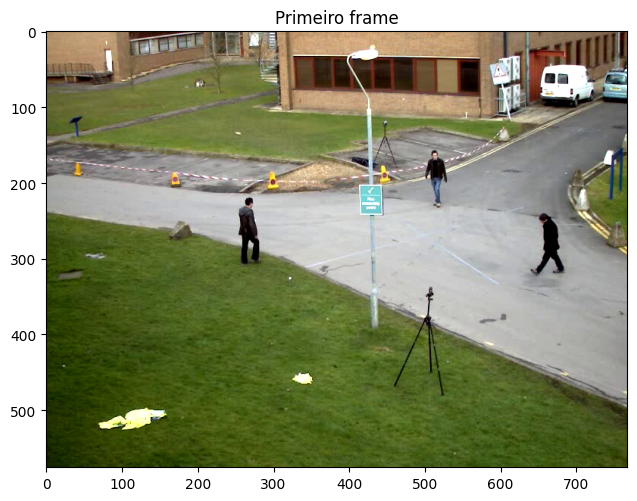

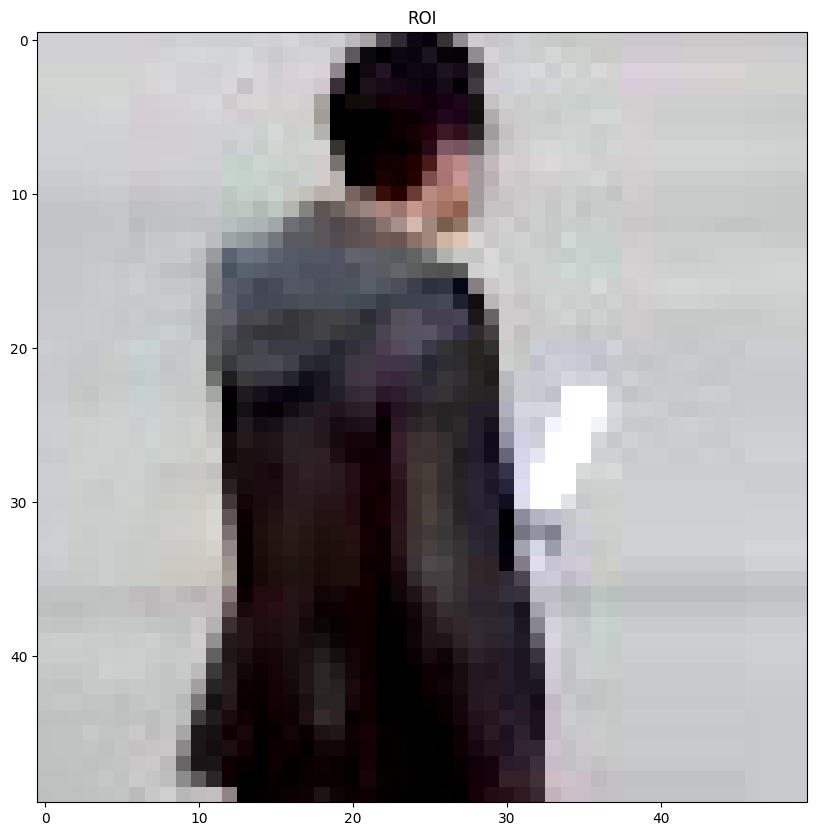

In [2]:
cap = cv2.VideoCapture('images/walking.avi')

ret, frame = cap.read()

imshow('Primeiro frame',frame)

# take first frame of the video
ret,frame = cap.read()

# Get the height and width of the frame (required to be an interger)
width = int(cap.get(3)) 
height = int(cap.get(4))

# Define the codec and create VideoWriter object. The output is stored in '*.avi' file.
out = cv2.VideoWriter('walking_tracking_mean_shift.avi', cv2.VideoWriter.fourcc('M','J','P','G'), 30, (width, height))

# local inicial da janela
r,h,c,w = 220,50,250,50  # simply hardcoded the values
track_window = (c,r,w,h)

# Região de interesse (ROI)
roi = frame[r:r+h, c:c+w] #Pegando a região, filtrando da imagem
imshow('ROI',roi)
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV) #Joga para o esçaço HSV

mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180]) #Calcula o histograma da região do ROI
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX) #Normaliza

# Configure os critérios de encerramento, 10 iterações ou movimentação de pelo menos 1 ponto
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

#cv2.TERM_CRITERIA_EPS Este critério encerra a iteração quando a mudança nos parâmetros 
# (por exemplo, a posição dos centros em k-means) for menor que um limite de precisão especificado.
# EPS significa "epsilon", ou seja, uma tolerância para o erro. 
# É útil quando você quer garantir que o algoritmo pare ao atingir um nível de estabilidade.

# cv2.TERM_CRITERIA_COUNT Este critério encerra a iteração quando o número máximo de iterações 
# especificado for alcançado, independentemente de outras condições.

while(1):
    ret, frame = cap.read()

    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        """ 
        A função cv2.calcBackProject do OpenCV é usada para calcular o backprojection de uma imagem. 
        O backprojection é um processo utilizado principalmente em tracking de objetos, 
        como no algoritmo CamShift ou MeanShift, para prever a posição de um objeto baseado em seu histograma.
        
        Backprojection é uma técnica que tenta localizar áreas de uma imagem (ou quadro de vídeo)
        que correspondem a um modelo ou histograma previamente calculado. Ele compara a distribuição 
        de cores de uma imagem com a distribuição do modelo (histograma) e cria uma imagem em escala de
        cinza onde cada valor de pixel indica a probabilidade de um determinado ponto fazer parte da 
        região de interesse.

        Parâmetros:
        images: A lista de imagens de entrada (geralmente uma imagem ou um único quadro de vídeo).

        channels: A lista de canais da imagem que serão usados para calcular o histograma. Normalmente, 
        você seleciona o canal de cor relevante (ex.: 0 para o canal de intensidade ou 1 para o canal de saturação, 
        dependendo da aplicação).

        hist: O histograma do modelo. Deve ser calculado previamente usando a função cv2.calcHist e armazenado.

        ranges: O intervalo de valores para os canais de cor. Para imagens no espaço de cores HSV, o intervalo 
        normalmente será [0, 256] para a intensidade e [0, 180] para o matiz (hue).
        
        scale: Um fator de escala opcional para multiplicar os valores do backprojection (geralmente definido como 1).

        """

        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,0),2)
        out.write(img2)
        #imshow('Tracking', img2)

    else:
        break

cap.release()
out.release()

In [3]:
!ffmpeg -i /content/car_tracking_mean_shift.avi car_tracking_mean_shift.mp4 -y

'ffmpeg' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('car_tracking_mean_shift.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

FileNotFoundError: [Errno 2] No such file or directory: 'car_tracking_mean_shift.mp4'

In [ ]:
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## **Camshift in OpenCV** 
It is almost same as meanshift, but it returns a rotated rectangle (that is our result) and box parameters (used to be passed as search window in next iteration). 

![](https://upload.wikimedia.org/wikipedia/commons/8/86/CamshiftStillImage.gif)

Read Paper Here - https://ieeexplore.ieee.org/document/732882

Animation Source - https://fr.wikipedia.org/wiki/Camshift

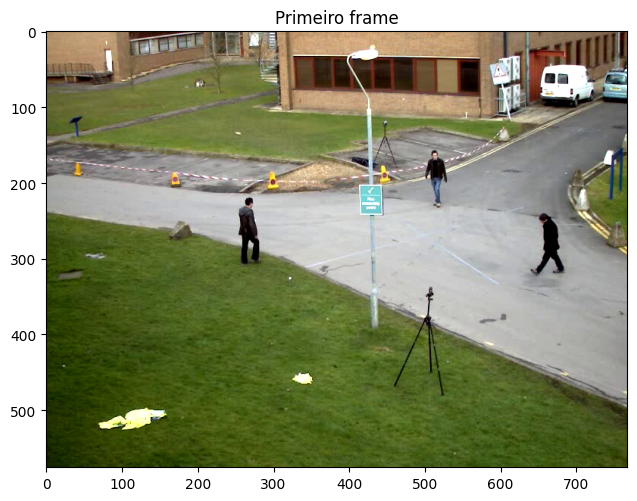

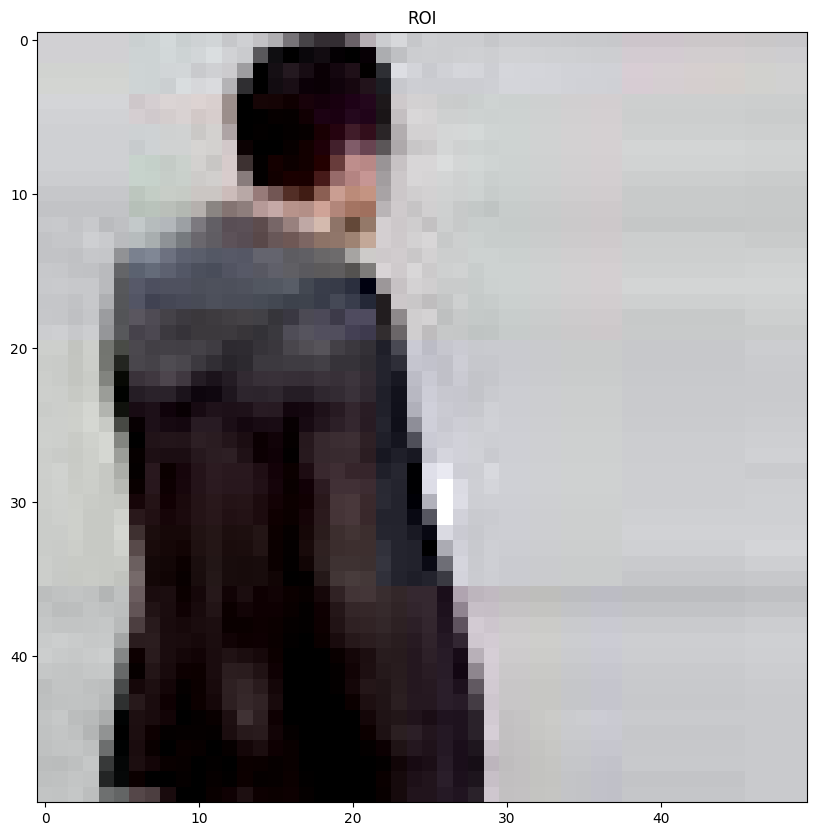

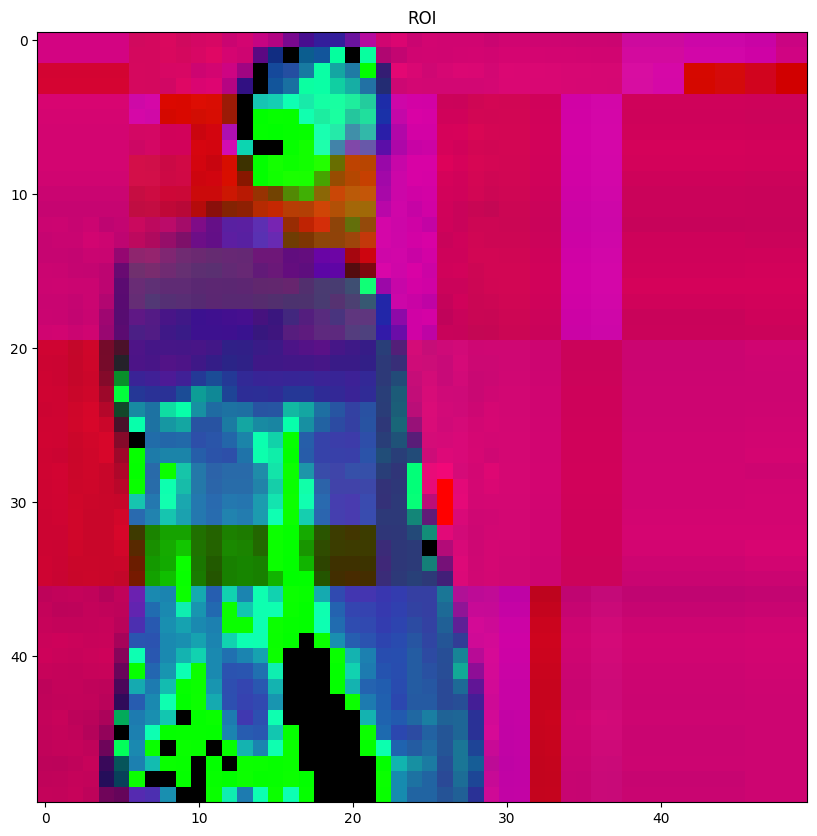

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_6980\2927610454.py:45: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  pts = np.int0(pts)


In [39]:
cap = cv2.VideoCapture('images/walking.avi')

# take first frame of the video
ret,frame = cap.read()

imshow('Primeiro frame',frame)

# Get the height and width of the frame (required to be an interger)
width = int(cap.get(3)) 
height = int(cap.get(4))

# Define the codec and create VideoWriter object. The output is stored in '*.avi' file.
out = cv2.VideoWriter('walking_tracking_cam_shift.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width, height))

# setup initial location of window
r,h,c,w = 220,50,250,50  # simply hardcoded the values
track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
imshow('ROI', roi)
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

imshow('ROI', hsv_roi)

mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)

        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        out.write(img2)
        #imshow('img2',img2)

    else:
        break

cap.release()
out.release()

| **Aspecto**               | **Mean Shift**                                           | **CamShift**                                             |
|---------------------------|----------------------------------------------------------|----------------------------------------------------------|
| **Definição**              | Algoritmo de rastreamento baseado em deslocamento iterativo de uma janela de amostra para o centro de massa de uma região de alta densidade no espaço de características (geralmente no espaço de cores). | Extensão do Mean Shift, que adapta o tamanho da janela de rastreamento durante o processo de rastreamento, tornando-o mais flexível para lidar com variações no objeto rastreado. |
| **Tamanho da Janela**      | O tamanho da janela de rastreamento é fixo ao longo de todas as iterações. | O tamanho da janela de rastreamento é ajustado dinamicamente, adaptando-se à forma e ao tamanho do objeto enquanto ele se move. |
| **Flexibilidade**          | Menos flexível, já que a janela tem um tamanho fixo e pode não se adaptar bem a objetos com mudanças de escala ou orientação. | Mais flexível, pois o algoritmo ajusta o tamanho da janela de acordo com o objeto, tornando-o mais eficaz para rastrear objetos em movimento, que podem mudar de tamanho. |
| **Resultado do Rastreamento** | O algoritmo retorna a posição da janela de rastreamento em cada iteração. | O CamShift não só fornece a posição da janela, mas também a **orientação** e **escala** do objeto, permitindo o rastreamento de objetos rotacionados ou que mudam de tamanho. |
| **Uso de Histograma**     | Usa o histograma da região de interesse (ROI) como um modelo de cor e realiza o rastreamento no espaço de cores (geralmente no espaço HSV). | Também usa o histograma para modelar a cor, mas com a vantagem de que pode atualizar o modelo de forma mais adaptativa. |
| **Critérios de Parada**   | O algoritmo termina quando o deslocamento é menor que um limiar de precisão ou quando um número máximo de iterações é alcançado. | O CamShift usa critérios semelhantes ao Mean Shift, mas inclui parâmetros de **tolerância** mais flexíveis devido ao ajuste dinâmico da janela. |
| **Desempenho em Escala**  | Pode ter dificuldades em rastrear objetos que mudam de escala, já que o tamanho da janela é fixo. | O CamShift pode lidar melhor com objetos que mudam de escala devido ao ajuste dinâmico da janela de rastreamento. |
| **Aplicações Típicas**    | Usado para rastrear objetos de tamanho e forma constantes em vídeos ou sequências de imagens. | Usado em rastreamento de objetos que podem mudar de forma, tamanho ou orientação, como rastreamento de pessoas ou veículos em movimento. |
| **Computação**            | Menos complexo, pois não há ajuste de escala ou orientação durante o rastreamento. | Mais complexo, pois envolve o ajuste da janela em termos de escala e orientação, o que aumenta a carga computacional. |
| **Algoritmo Base**        | Mean Shift é a base do CamShift. O CamShift é uma melhoria do Mean Shift com mais flexibilidade. | CamShift é uma extensão e melhoria do Mean Shift, com capacidades adicionais de ajuste da janela e rastreamento mais robusto. |


In [ ]:
!ffmpeg -i /content/car_tracking_cam_shift.avi car_tracking_cam_shift.mp4 -y

In [9]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('car_tracking_cam_shift.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [ ]:
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)